In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

/home/george/micromamba/envs/trans/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
path = 'data/what2.jpg'
image = Image.open(path).convert("RGB")

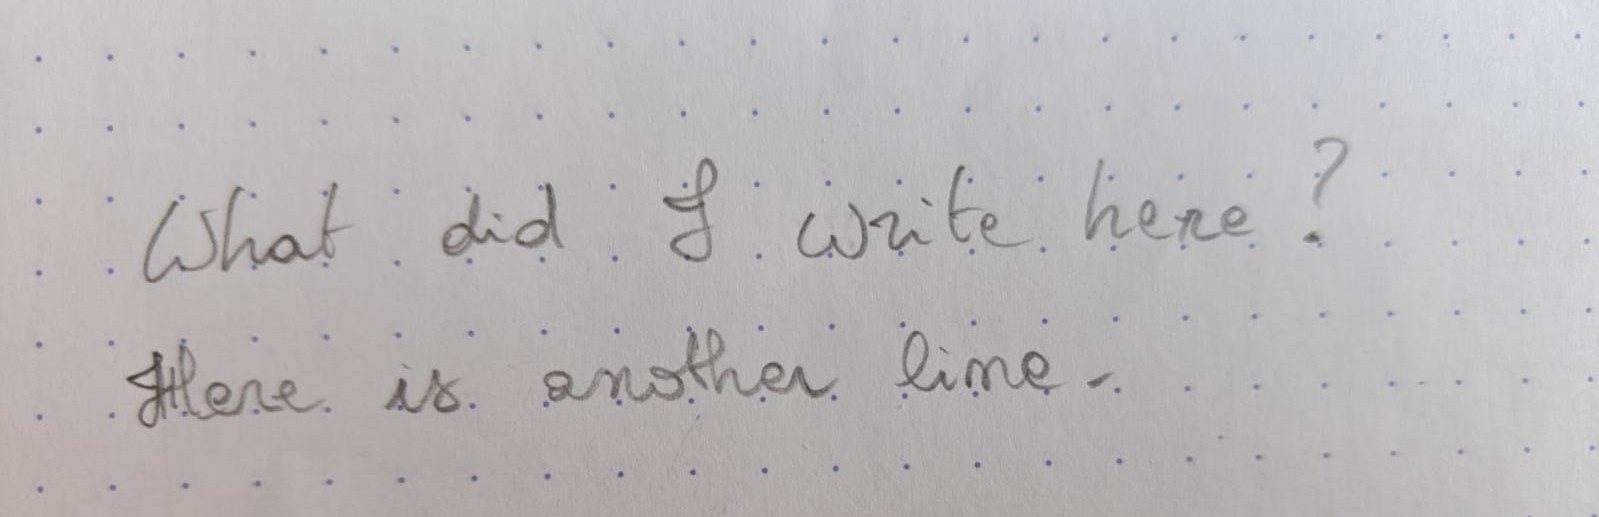

In [18]:
image

In [ ]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
pixel_values = processor(images=image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

'# good and the most important man because of'

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/home/george/micromamba/envs/trans/lib/python3.12/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Detected: '(shal' with confidence 0.43
Detected: 'ad' with confidence 0.77
Detected: '3' with confidence 0.93
Detected: 'iule .' with confidence 0.50
Detected: 'heze' with confidence 0.98
Detected: 'dlene .' with confidence 0.66
Detected: 'Ns.' with confidence 0.28
Detected: 'ahslhea `' with confidence 0.07
Detected: 'Gime' with confidence 0.48


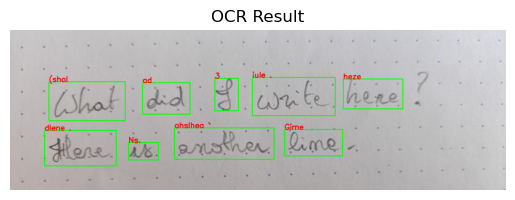

In [22]:
# Install dependencies (run once)
# pip install easyocr opencv-python

import easyocr
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'data/what2.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize EasyOCR Reader (use GPU if available)
reader = easyocr.Reader(['en'], gpu=True)  # Set gpu=False if no GPU

# Perform OCR
results = reader.readtext(image)

# Display detected text and bounding boxes
for (bbox, text, prob) in results:
    print(f"Detected: '{text}' with confidence {prob:.2f}")

# Optional: visualize results
for (bbox, text, prob) in results:
    top_left = tuple([int(val) for val in bbox[0]])
    bottom_right = tuple([int(val) for val in bbox[2]])
    cv2.rectangle(image_rgb, top_left, bottom_right, (0, 255, 0), 2)
    cv2.putText(image_rgb, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

plt.imshow(image_rgb)
plt.axis('off')
plt.title("OCR Result")
plt.show()


Combine EasyOCR and TrOCR

In [24]:
import easyocr
import cv2
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
import numpy as np

# Load models
reader = easyocr.Reader(['en'], gpu=True)  # Text detection
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# Load image
image_path = "data/what2.jpg"
image = cv2.imread(image_path)

# Detect text regions using EasyOCR
results = reader.readtext(image, detail=1)

# Sort by vertical position (top to bottom)
results = sorted(results, key=lambda x: x[0][0][1])

recognized_texts = []

for (bbox, _, _) in results:
    # Extract bounding box and crop
    pts = np.array(bbox).astype(int)
    x_min = np.min(pts[:, 0])
    x_max = np.max(pts[:, 0])
    y_min = np.min(pts[:, 1])
    y_max = np.max(pts[:, 1])
    cropped = image[y_min:y_max, x_min:x_max]

    # Convert cropped region to PIL and RGB
    cropped_pil = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

    # TrOCR preprocessing and prediction
    pixel_values = processor(images=cropped_pil, return_tensors="pt").pixel_values
    generated_ids = trocr_model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    recognized_texts.append(text)

# Print the results
print("Final recognized lines:\n")
for line in recognized_texts:
    print(line)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Final recognized lines:

civicities .
gif
theine .
lisliot
did
simisthen .
lime .
ytillerie .
its .


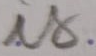

In [25]:
cropped_pil

Cut lines with EasyOCR

In [35]:
import easyocr
import cv2
import numpy as np

# Load image
image = cv2.imread("data/what2.jpg")
H, W, _ = image.shape

# Detect text with EasyOCR
reader = easyocr.Reader(['en'], gpu=True)
results = reader.readtext(image, detail=1)

# Extract bounding boxes and sort by y center
boxes = [(np.mean([pt[1] for pt in bbox]), bbox) for bbox, _, _ in results]
boxes.sort(key=lambda x: x[0])

# Cluster into lines (simple vertical clustering with tolerance)
lines = []
tolerance = 25  # adjust based on writing size

for y_center, bbox in boxes:
    added = False
    for line in lines:
        if abs(line['mean_y'] - y_center) < tolerance:
            line['boxes'].append(bbox)
            all_y = [pt[1] for box in line['boxes'] for pt in box]
            line['mean_y'] = np.mean(all_y)
            added = True
            break
    if not added:
        lines.append({'boxes': [bbox], 'mean_y': y_center})

# Crop full-width line images
line_images = []
for line in lines:
    all_pts = np.concatenate(line['boxes'], axis=0)
    y_min = max(0, int(np.min(all_pts[:, 1])) - 5)
    y_max = min(H, int(np.max(all_pts[:, 1])) + 5)
    cropped = image[y_min:y_max, 0:W]  # full width
    line_images.append(cropped)

In [36]:
len(line_images)

2

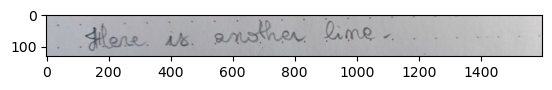

In [37]:
plt.imshow(line_images[1])

In [39]:
i=1

pixel_values = processor(images=line_images[i], return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

'" There is another line : 1.000,'

New try with GOT-OCR 2.0

In [1]:
from transformers import AutoProcessor, AutoModelForImageTextToText
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForImageTextToText.from_pretrained("stepfun-ai/GOT-OCR-2.0-hf", device_map=device)
processor = AutoProcessor.from_pretrained("stepfun-ai/GOT-OCR-2.0-hf", use_fast=True)

/home/george/micromamba/envs/trans/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
model = model.eval().to(device)

In [8]:
image = "data/what.jpg"
inputs = processor(image, return_tensors="pt", device=device).to(device)

generate_ids = model.generate(
    **inputs,
    do_sample=False,
    tokenizer=processor.tokenizer,
    stop_strings="<|im_end|>",
    max_new_tokens=4096,
)

res = processor.decode(generate_ids[0, inputs["input_ids"].shape[1]:], skip_special_tokens=True)

In [5]:
res = res.replace("\\title", "\\title ")

In [9]:
res

':What?did?Whitehere?'

In [10]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True)
model = AutoModel.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True, low_cpu_mem_usage=True, device_map='cuda', use_safetensors=True, pad_token_id=tokenizer.eos_token_id)
model = model.eval().cuda()


# input your test image
image_file = 'data/what.jpg'

# plain texts OCR
res = model.chat(tokenizer, image_file, ocr_type='ocr')

Encountered exception while importing tiktoken: No module named 'tiktoken'


ImportError: This modeling file requires the following packages that were not found in your environment: tiktoken. Run `pip install tiktoken`